In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_49937/884013642.py:20: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [2]:
def contract_to_unisphere(
    x: torch.Tensor,
    ord: float = 2,
    eps: float = 1e-6,
    derivative: bool = False,
    cdf_lb: float = 0.1,
    num_bins: int = 1000,
):  
    x_pdf, x_pos = torch.histogram(x[:, 0].cpu(), bins=num_bins)
    y_pdf, y_pos = torch.histogram(x[:, 1].cpu(), bins=num_bins)
    z_pdf, z_pos = torch.histogram(x[:, 2].cpu(), bins=num_bins)
    x_cdf, x_pos = torch.cumsum(x_pdf, dim=0) / x.shape[0], x_pos[:-1]
    y_cdf, y_pos = torch.cumsum(y_pdf, dim=0) / x.shape[0], y_pos[:-1]
    z_cdf, z_pos = torch.cumsum(z_pdf, dim=0) / x.shape[0], z_pos[:-1]

    aabb = torch.tensor([
        x_pos[x_cdf > cdf_lb].min(),
        y_pos[y_cdf > cdf_lb].min(),
        z_pos[z_cdf > cdf_lb].min(),
        x_pos[x_cdf > 1 - cdf_lb].min(),
        y_pos[y_cdf > 1 - cdf_lb].min(),
        z_pos[z_cdf > 1 - cdf_lb].min(),
    ], device=x.device)
    aabb_min, aabb_max = torch.split(aabb, aabb.shape[0] // 2, dim=-1)
    x = (x - aabb_min) / (aabb_max - aabb_min)
    x = x * 2 - 1  # aabb is at [-1, 1]
    mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
    mask = mag.squeeze(-1) > 1

    if derivative:
        dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
            1 / mag**3 - (2 * mag - 1) / mag**4
        )
        dev[~mask] = 1.0
        dev = torch.clamp(dev, min=eps)
        return dev
    else:
        x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
        x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
        return x

def get_flowid(frames, flows):
    N, _, H, W = frames.shape
    flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
    flow_ids[0] = torch.arange(H * W).view(H, W)
    last_id = H * W

    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid_y = grid_y.to(device=frames.device)
    grid_x = grid_x.to(device=frames.device)
    diff_threshold = frames.max().item() * 0.1
    for i in tqdm(range(1, N), desc="Assigning flow ids"):
        x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
        y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
        mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
        # cut off flow when error is significant
        diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < diff_threshold
        flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

        unassigned = (flow_ids[i] == -1)
        flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
        last_id += unassigned.sum()
    
    return flow_ids

def voxelization(flow_ids, in_feats_rgb, in_feats_coord, voxel_size, xyz_min=None, contract=False):
    with torch.no_grad():
        # automatically determine the voxel size
        _, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(in_feats_rgb, unq_inv_t, dim=0, reduce='mean')
        feats_coord = torch_scatter.scatter(in_feats_coord, unq_inv_t, dim=0, reduce='mean')

        # contract to unit sphere
        # decide aabb according to density
        if contract:
            feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
        if xyz_min is None:
            xyz_min = torch.min(feats_coord, dim=0).values
        voxel_size = torch.tensor([voxel_size] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
        voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
        feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')

        unq_inv = unq_inv_xyz[unq_inv_t]

        return unq_inv

def warp_flow(frames, past_flows):
    
    N, _, H, W = frames.shape
    flow_new = past_flows[:, :2].clone()
    flow_new[:, 0, :, :] += torch.arange(W, device=flow_new.device)
    flow_new[:, 1, :, :] += torch.arange(H, device=flow_new.device)[:, None]
    # resides flow_new to [-1, 1]
    flow_new[:, 0] = (flow_new[:, 0] / (W - 1) - 0.5) * 2
    flow_new[:, 1] = (flow_new[:, 1] / (H - 1) - 0.5) * 2
    frame_warp = F.grid_sample(frames, flow_new.permute(0, 2, 3, 1), mode='bicubic', padding_mode='zeros', align_corners=True)

    return frame_warp

def compute_fwdbwd_mask(fwd_flow, bwd_flow, alpha=0.1):

    bwd2fwd_flow = warp_flow(bwd_flow, fwd_flow)
    fwd_lr_error = torch.linalg.norm(fwd_flow + bwd2fwd_flow, dim=1)
    fwd_mask = fwd_lr_error < alpha * (torch.linalg.norm(fwd_flow, dim=1) + torch.linalg.norm(bwd2fwd_flow, dim=1)) + alpha

    fwd2bwd_flow = warp_flow(fwd_flow, bwd_flow)
    bwd_lr_error = torch.linalg.norm(bwd_flow + fwd2bwd_flow, dim=1)
    bwd_mask = bwd_lr_error < alpha * (torch.linalg.norm(bwd_flow, dim=1) + torch.linalg.norm(fwd2bwd_flow, dim=1)) + alpha

    return fwd_mask, bwd_mask

def get_mask_bwds(gt_path, flows, past_flows, device='cuda', dtype=torch.float16):

    pil_list = eu.video_to_pil_list(gt_path)
    org_images = torch.concat([eu.load_image(pil, device, dtype) for pil in pil_list], dim=0) / 255.0

    mask_bwds = torch.ones_like(org_images[:, 0], dtype=torch.bool)
    _, mask_bwds[1:] = compute_fwdbwd_mask(flows[:-1], past_flows[1:])
    org_images_warp = warp_flow(org_images[:-1], past_flows[1:])
    mask_bwds[1:] &= (org_images_warp - org_images[1:]).abs().max(dim=1).values < org_images.max().item() * 0.1
    mask_bwds = mask_bwds[:, None, ...].repeat(1, 3, 1, 1)

    return mask_bwds

## 1. Optimization

In [3]:
import torch
from typing import List, Optional, Tuple, Union
from torch import Tensor
from pytorch_msssim import ms_ssim
from pytorch_msssim.ssim import gaussian_filter, _fspecial_gauss_1d

def _relaxed_ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float,
    win: Tensor,
    l_activate_func=lambda x: x,
    cs_activate_func=lambda x: x,
    flatten: bool = True,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03)
) -> Tuple[Tensor, Tensor]:
    r""" Calculate ssim index for X and Y

    Args:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        data_range (float or int): value range of input images. (usually 1.0 or 255)
        win (torch.Tensor): 1-D gauss kernel
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = cs_activate_func((2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))  # set alpha=beta=gamma=1
    ssim_map = l_activate_func((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    if flatten:
        ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
        cs = torch.flatten(cs_map, 2).mean(-1)
        return ssim_per_channel, cs
    else:
        return ssim_map, cs_map

def relaxed_ms_ssim(
    X: Tensor,
    Y: Tensor,
    l_activate_func=lambda x: x,
    cs_activate_func=lambda x: x,
    start_level: int = 0,
    data_range: float = 255,
    size_average: bool = True,
    win_size: int = 11,
    win_sigma: float = 1.5,
    win: Optional[Tensor] = None,
    weights: Optional[List[float]] = None,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03)
) -> Tensor:
    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    #if not X.type() == Y.type():
    #    raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights_tensor = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights_tensor.shape[0]
    mcs = []
    for i in range(levels):
        if i >= start_level:
            ssim_per_channel, cs = _relaxed_ssim(X, Y, l_activate_func=l_activate_func, cs_activate_func=cs_activate_func, win=win, data_range=data_range, K=K)
        else:
            ssim_per_channel = torch.ones_like(X[:, :, 0, 0])
            cs = torch.ones_like(X[:, :, 0, 0])

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # type: ignore  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights_tensor.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)

In [4]:
output_dir = "../workdir/sceneflow/sceneflow_highres_sky_lmr_0.2_gmr_0.1_vox_None"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device, dtype=torch.float32)
    data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    _, _, _, flows, past_flows =  data_parser.load_video(frame_ids)
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

Reading camera data: 100%|██████████| 300/300 [00:00<00:00, 93151.55it/s]


[INFO] frame indexes:  0 1 ... 298 299


Loading Data:   0%|          | 0/300 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 300/300 [00:07<00:00, 39.08it/s]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Loading Flows: 100%|██████████| 300/300 [00:01<00:00, 150.25it/s]
/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Assigning flow ids: 100%|██████████| 299/299 [00:00<00:00, 669.32it/s]


[INFO] Scatter with Time&Spatial Dimention.
Total number of unique voxels: 91533537 / 147456000


In [21]:
import datetime
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, VGGPerceptualLoss
from utils.dataloader import OptDataset

vgg_loss = VGGPerceptualLoss(resize=False)
max_sh_degree = 3
lambda_dssim = 0.2
lambda_perceptual = 0.01
lambda_flow = 0.8
lambda_exp = 0.8
epochs_exposure = 35
epochs = 70
batch_size = 16
iterations = epochs_exposure * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0

/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
mask_bwds = get_mask_bwds(f'{output_dir}/output_gt.gif', flows, past_flows, flows.device, flows.dtype)

pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

dataset = OptDataset(
    edited_images,
    past_flows,
    mask_bwds,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

del edited_images, pil_list, mask_bwds

In [23]:
SHOW_INTEGRATION_RESULTS = False
if SHOW_INTEGRATION_RESULTS:
    with torch.no_grad():
        pil_list = eu.video_to_pil_list(f'{output_dir}/output_gt.gif')
        org_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0
        
        pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
        pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')
        print(f"Total number of unique voxels: {pil_tensor.shape[0]} / {N * H * W}")

        images = pil_tensor[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
        images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
        edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
        org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

    plt.style.use("seaborn-v0_8-whitegrid")
    idx = random.randint(0, N-1)
    idx = 70
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images_np[idx])
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(org_images_np[idx])
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

In [22]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

loss_list_exposure = []
pbar = tqdm(total=epochs_exposure, desc="Optimizing Exposures")

exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

for epoch in range(epochs_exposure):
    for i, (idxs, _edited_images, _pre_edited_images, _past_flows, _mask_bwds) in enumerate(data_loader):

        iteration = epoch * len(frame_ids) // batch_size + i + 1
        for param_group in exposure_optimizer.param_groups:
            param_group['lr'] = exposure_scheduler_args(iteration)

        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = torch.bmm(cat_images.permute(0, 2, 3, 1).reshape(-1, H*W, 3), exposure[cat_idxs, :3, :3]) + exposure[cat_idxs, None, :3, 3]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(-1, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        loss_photometric = l1_loss(images, _edited_images) * (1 - lambda_dssim) + \
                            (1.0 - ms_ssim(images, _edited_images, data_range=1)) * lambda_dssim

        warped_images = warp_flow(pre_images, _past_flows)[idxs>0]
        images, _mask_bwds = images[idxs>0], _mask_bwds[idxs>0]

        loss_flow = l1_loss(warped_images[_mask_bwds], images[_mask_bwds])

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list_exposure.append(loss.item())

        loss.backward()

        exposure_optimizer.step()
        exposure_optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

dataset.exposure_align(exposure)

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Exposures:   0%|          | 0/35 [00:00<?, ?it/s]

Optimizing Exposures: 100%|██████████| 35/35 [01:38<00:00,  2.83s/it, loss=0.042463, loss_flow=0.042756, loss_photometric=0.041292]

Memory: 14974.44 MB
Time: 98.886517s


In [10]:
ANALYZE_SSIM = False
if ANALYZE_SSIM:
    with torch.no_grad():
        pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
        pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

    images = pil_tensor[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
    images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

    # idx = random.randint(0, N-1)
    idx = 244
    ssim = relaxed_ms_ssim(images[idx:idx+1], dataset.edited_images[idx:idx+1], data_range=1, start_level=4)
    print(f"SSIM of Frame {idx}: {ssim.item()}")

    # win = _fspecial_gauss_1d(11, 1.5)
    # win = win.repeat([images.shape[1]] + [1] * (len(images.shape) - 1))
    # ssim_map, cs_map = _relaxed_ssim(images[idx:idx+1], dataset.edited_images[idx:idx+1], win=win, data_range=1, flatten=False)
    # l_map = ssim_map / cs_map

    # show distribution of per-channel SSIM
    plt.style.use("seaborn-v0_8-whitegrid")
    # plt.hist(l_map[0, 0].reshape(-1).cpu().numpy(), bins=100, color='r', alpha=0.5, label='R');
    # plt.hist(l_map[0, 1].reshape(-1).cpu().numpy(), bins=100, color='g', alpha=0.5, label='G');
    # plt.hist(l_map[0, 2].reshape(-1).cpu().numpy(), bins=100, color='b', alpha=0.5, label='B');

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(dataset.edited_images[idx].permute(1, 2, 0).cpu().numpy())
    # plt.imshow(l_map[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

In [17]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

with torch.no_grad():
    pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

fused_color = RGB2SH(pil_tensor)
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

loss_list = []

pbar = tqdm(total=epochs, desc="Optimizing Unique Tensor")
quant_scalor = 8.0 / 255.0

for epoch in range(epochs):
    for i, (idxs, _edited_images, _, _past_flows, _mask_bwds) in enumerate(data_loader):
        # iteration = epoch * len(frame_ids) // batch_size + i + 1
        _mask_bwds = _mask_bwds[idxs>0]
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        unq_inv = data_parser.unq_inv.reshape(N, H, W, -1)[cat_idxs].reshape(-1)
        cat_images = SH2RGB(features_dc)[unq_inv].reshape(len(cat_idxs), H*W, -1) # N x HW x 3
        cat_images = torch.clamp(cat_images, 0, 1).reshape(len(cat_idxs), H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        warped_images = warp_flow(pre_images, _past_flows)
        
        loss_flow = l1_loss(warped_images[idxs>0][_mask_bwds], images[idxs>0][_mask_bwds])
        
        # quantize images to relax the restriction
        # loss_ssim = (1.0 - ms_ssim(images, _edited_images, data_range=1)) * lambda_dssim
        # loss_ssim_org = (1.0 - ms_ssim(rgb_to_grayscale(images), rgb_to_grayscale(org_images[idxs]), data_range=1)) * lambda_dssim * 0.2
        # loss_photometric = loss_ssim + loss_ssim_org

        loss_photometric = (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, 
                                                  start_level=1)) * lambda_dssim
        
        # loss_photometric = vgg_loss(images, _edited_images, feature_layers=[3]) * lambda_perceptual

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list.append(loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none = True)

    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Unique Tensor:   0%|          | 0/70 [00:00<?, ?it/s]

Optimizing Unique Tensor: 100%|██████████| 70/70 [02:23<00:00,  2.06s/it, loss=0.007970, loss_flow=0.004793, loss_photometric=0.020675]

Memory: 17131.87 MB
Time: 144.00373s


Text(0.5, 1.0, 'Loss curve for unique tensor optimization')

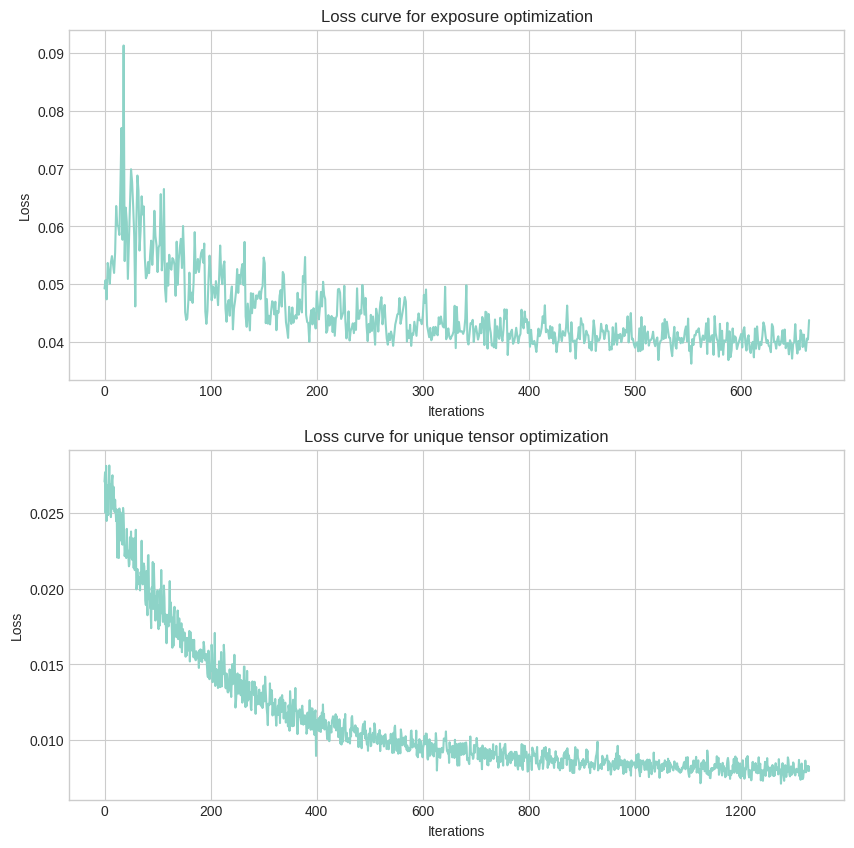

In [18]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_list_exposure)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for exposure optimization")

plt.subplot(2, 1, 2)
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for unique tensor optimization")

In [19]:
images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
# images = torch.bmm(images, exposure[:, :3, :3]) + exposure[:, None, :3, 3]
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
save_name = f"opt_lr_{feature_lr:3f}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_ssim_{lambda_dssim}_slevel1_ep{epochs}_loss_{loss_list[-1]:.3f}"
cur_output_path = os.path.join(output_dir, save_name)
save_video(images, cur_output_path, save_frame=True)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/sceneflow/sceneflow_highres_sky_lmr_0.2_gmr_0.1_vox_None/opt_lr_0.002667_lambda_flow_0.8_lambda_exp_0.8_ssim_0.5_slevel1_ep70_loss_0.008/output.gif


0

In [13]:
# coords_mask = ((coords_w.abs()[:, 0:1] > 50) & (coords_w.abs()[:, 1:2] > 50)).repeat(1, 3, 1, 1)
images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
# images[coords_mask] = 0

In [14]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 959.5, 511.5, -0.5)

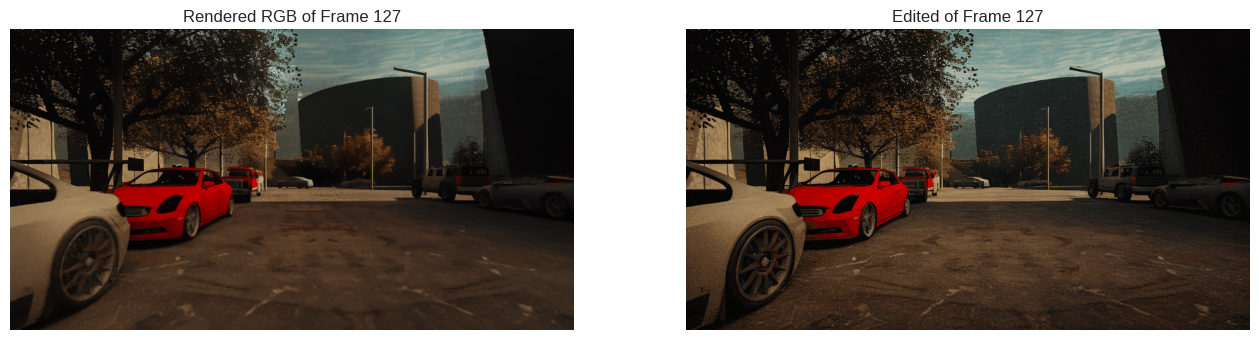

In [15]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
# idx = 187
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
plt.axis("off")